In [1]:
import datetime
import requests
import pandas
import unlzw3
import os
from pathlib import Path
from io import StringIO 
from datetime import date
from astropy.io import fits
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
eso_url = 'https://dataportal.eso.org/dataPortal/file/'
example_url = 'https://dataportal.eso.org/dataPortal/file/FEROS.2025-10-11T18:01:15.608'
ref_WLC_url = 'https://dataportal.eso.org/dataPortal/file/FEROS.2005-08-17T20:59:31.561'
files_dict = {"now":{'url':example_url,'filename':'FEROS_NOW'},"ref":{'url':ref_WLC_url,'filename':'FEROS_REFERENCE'}}

Axes(0.125,0.11;0.352273x0.77) now
Axes(0.547727,0.11;0.352273x0.77) ref


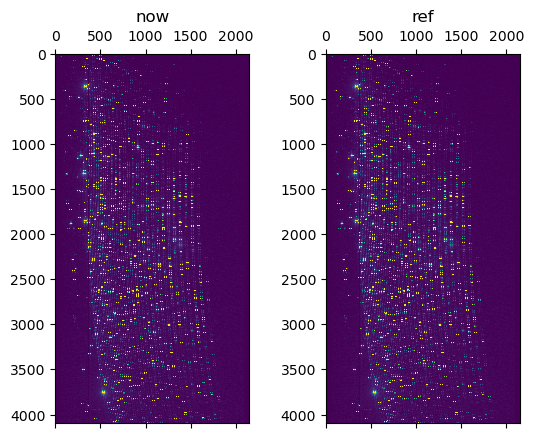

In [3]:
vmin=250;vmax=500
keys = files_dict.keys()
fig,ax=plt.subplots(nrows=1,ncols=len(keys))
for a,k in zip(ax,keys):
  filename = files_dict[k]["filename"]
  filename_zip = filename+".Z"
  urlretrieve(example_url, filename=filename_zip)
  extracted_data = unlzw3.unlzw(Path(filename_zip))
  filename_fits = filename+".fits"
  if os.path.exists(filename_fits): os.remove(filename_fits)
  file_now = open(filename_fits,"wb")
  file_now.write(extracted_data)
  file_now.close()
  hdu = fits.open(filename_fits,ignore_missing_simple=True)
  a.matshow(hdu[0].data,vmin=vmin,vmax=vmax)
  a.set_title(k)
  print(a,k)